In [4]:
%matplotlib inline
import os
import cv2
import numpy as np
import lpips
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_psnr_y(gt, pred):
    gt_y = cv2.cvtColor(gt, cv2.COLOR_RGB2YCrCb)[:,:,0]
    pred_y = cv2.cvtColor(pred, cv2.COLOR_RGB2YCrCb)[:,:,0]
    return psnr(gt_y, pred_y, data_range=255)

def calculate_ssim_y(gt, pred):
    gt_y = cv2.cvtColor(gt, cv2.COLOR_RGB2YCrCb)[:,:,0]
    pred_y = cv2.cvtColor(pred, cv2.COLOR_RGB2YCrCb)[:,:,0]
    return ssim(gt_y, pred_y, data_range=255)

def create_comparison_figure(gt_img, result_img, diff_img, psnr_val, ssim_val, lpips_val):
    plt.figure(figsize=(24, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Result")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(diff_img, cmap='jet')
    plt.title("Difference Map")
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 4, 4)
    metrics_text = f"PSNR-Y: {psnr_val:.2f}\nSSIM-Y: {ssim_val:.4f}\nLPIPS: {lpips_val:.4f}"
    plt.text(0.1, 0.5, metrics_text, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_images(gt_dir, result_dir, output_dir=None, show_samples=3):
    loss_fn = lpips.LPIPS(net='vgg').cuda() if torch.cuda.is_available() else lpips.LPIPS(net='vgg')
    metrics = {
        'psnr': [],
        'ssim': [],
        'lpips': [],
        'scores': []
    }

    sample_count = 0

    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(gt_dir):
        rel_path = os.path.relpath(root, gt_dir)
        result_root = os.path.join(result_dir, rel_path)

        if not os.path.exists(result_root):
            continue

        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                gt_path = os.path.join(root, file)
                result_path = os.path.join(result_root, file)

                if not os.path.exists(result_path):
                    print(f"Warning: Missing result file {result_path}")
                    continue

                gt_img = cv2.imread(gt_path)
                result_img = cv2.imread(result_path)

                original_h, original_w = gt_img.shape[:2]

                if result_img.shape[:2] != (original_h, original_w):
                    #print(original_h, original_w)
                    result_img = cv2.resize(result_img,
                                            (original_w, original_h),
                                            interpolation=cv2.INTER_CUBIC)

                gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
                result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

                current_psnr = calculate_psnr_y(gt_rgb, result_rgb)
                current_ssim = calculate_ssim_y(gt_rgb, result_rgb)

                gt_tensor = lpips.im2tensor(gt_rgb)
                result_tensor = lpips.im2tensor(result_rgb)
                if torch.cuda.is_available():
                    gt_tensor = gt_tensor.cuda()
                    result_tensor = result_tensor.cuda()
                current_lpips = loss_fn(gt_tensor, result_tensor).item()

                metrics['psnr'].append(current_psnr)
                metrics['ssim'].append(current_ssim)
                metrics['lpips'].append(current_lpips)
                metrics['scores'].append(current_psnr + 10*current_ssim - 5*current_lpips)

                diff = cv2.absdiff(gt_img, result_img)
                diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

                if sample_count < show_samples:
                    create_comparison_figure(gt_img, result_img, diff,
                                             current_psnr, current_ssim, current_lpips)
                    sample_count += 1

                if output_dir:
                    fig = plt.figure(figsize=(24, 8))
                    plt.savefig(os.path.join(output_dir, f"comparison_{file}"))
                    plt.close()

    final_metrics = {
        'avg_psnr': np.mean(metrics['psnr']),
        'avg_ssim': np.mean(metrics['ssim']),
        'avg_lpips': np.mean(metrics['lpips']),
        'final_score': np.mean(metrics['scores'])
    }

    print("\nSummary Metrics:")
    print(f"Average PSNR-Y: {final_metrics['avg_psnr']:.4f}")
    print(f"Average SSIM-Y: {final_metrics['avg_ssim']:.4f}")
    print(f"Average LPIPS: {final_metrics['avg_lpips']:.4f}")
    print(f"Final Challenge Score: {final_metrics['final_score']:.4f}")

    return final_metrics, metrics

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\tudda\anaconda3\Lib\site-packages\lpips\weights\v0.1\vgg.pth
Resizing 00001.png from (256, 256) to (480, 720)


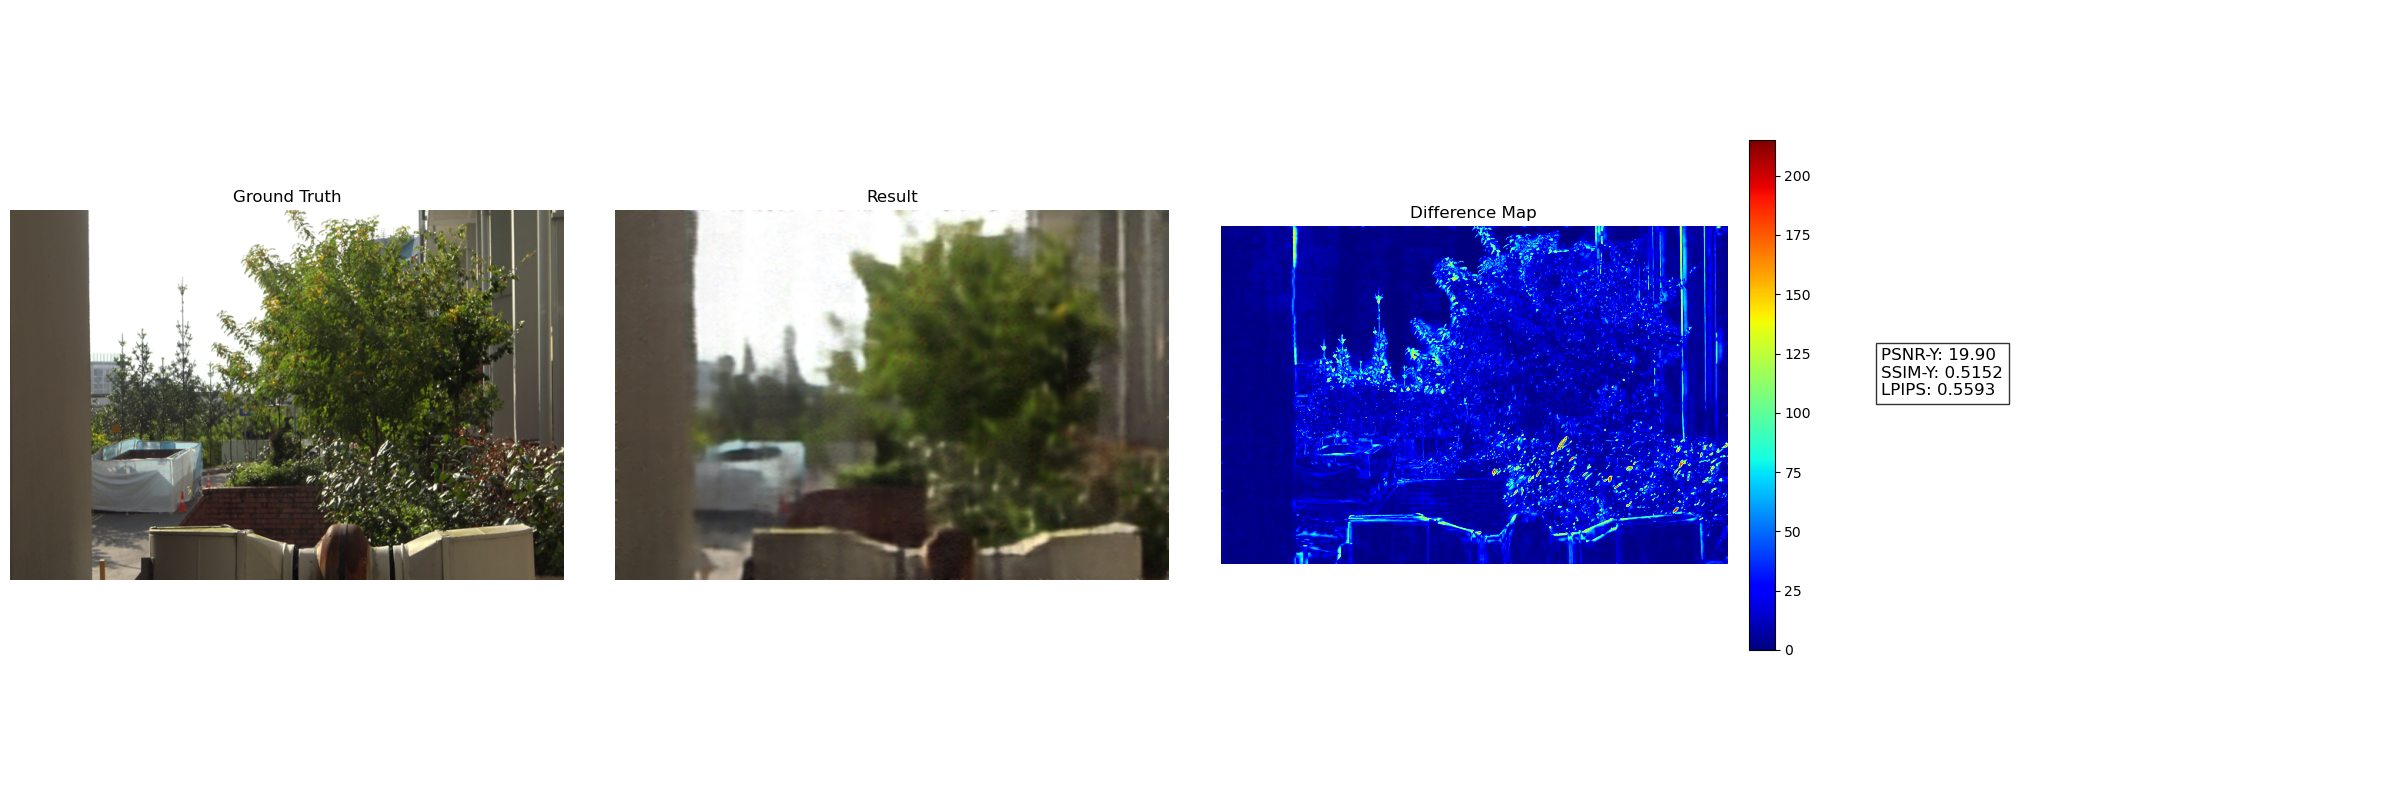

Resizing 00002.png from (256, 256) to (480, 720)


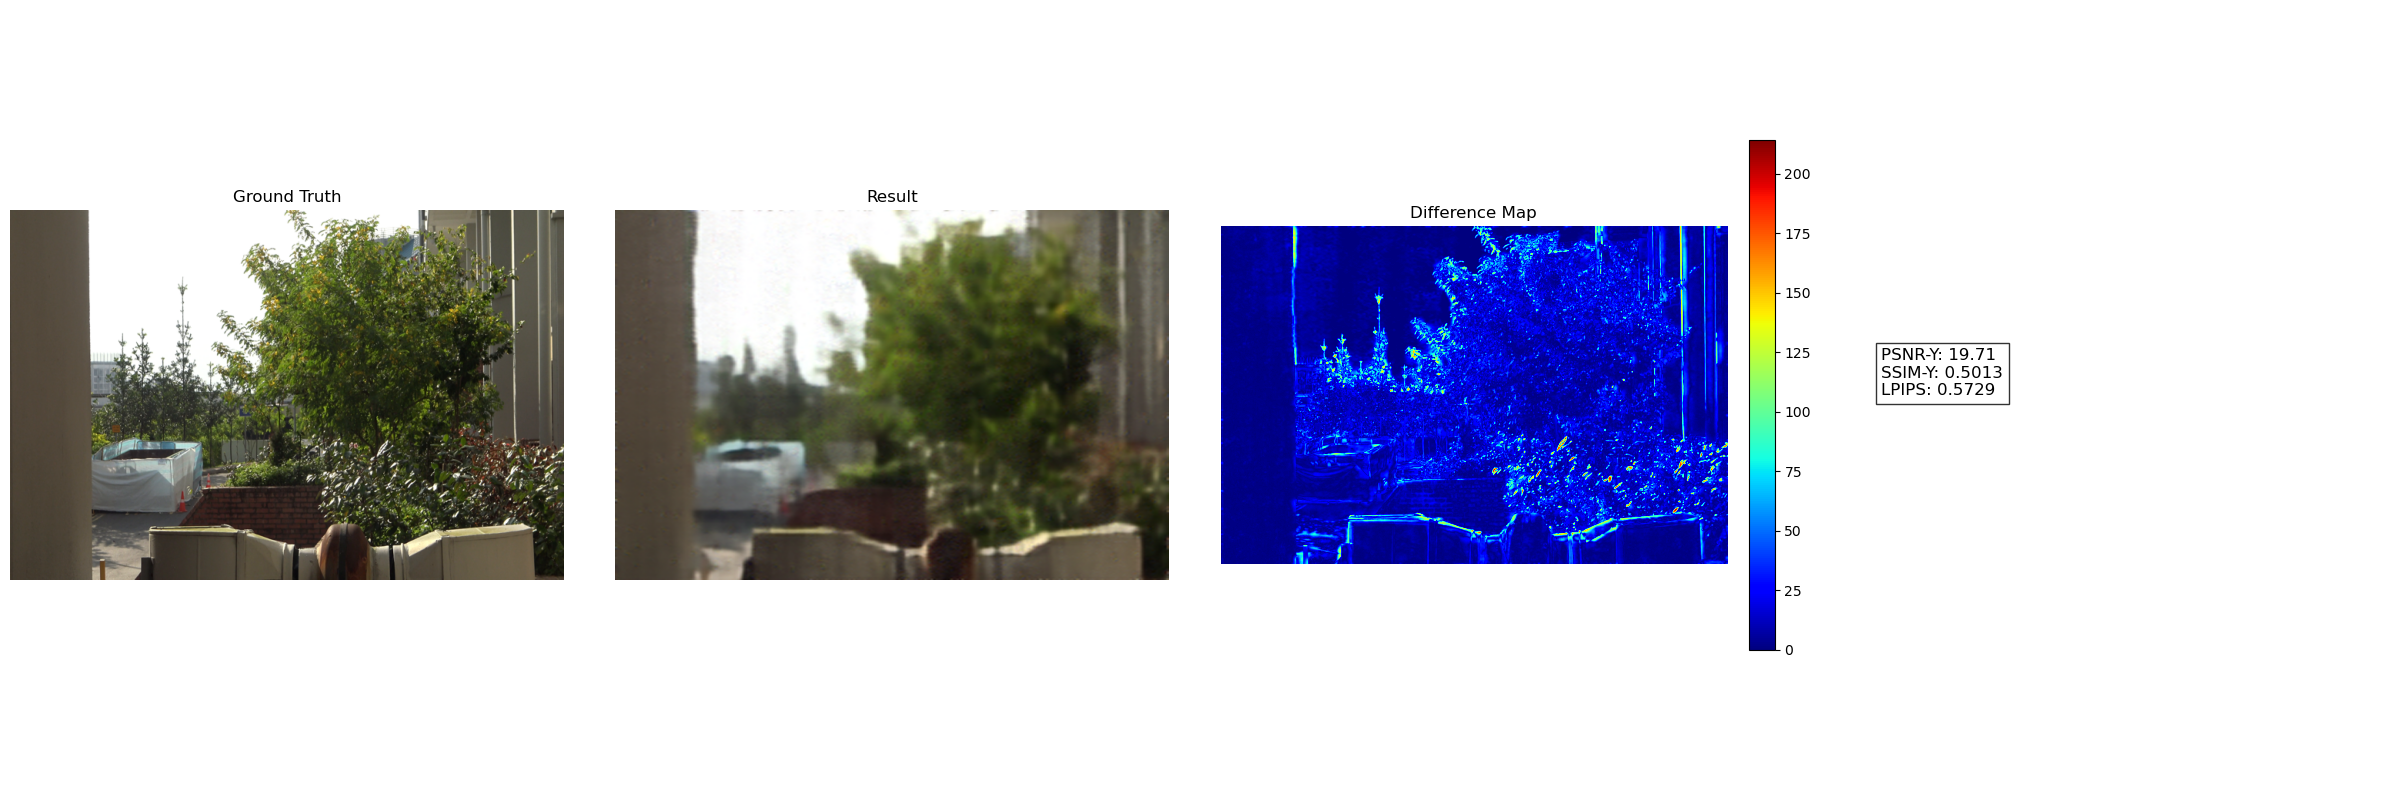

Resizing 00003.png from (256, 256) to (480, 720)


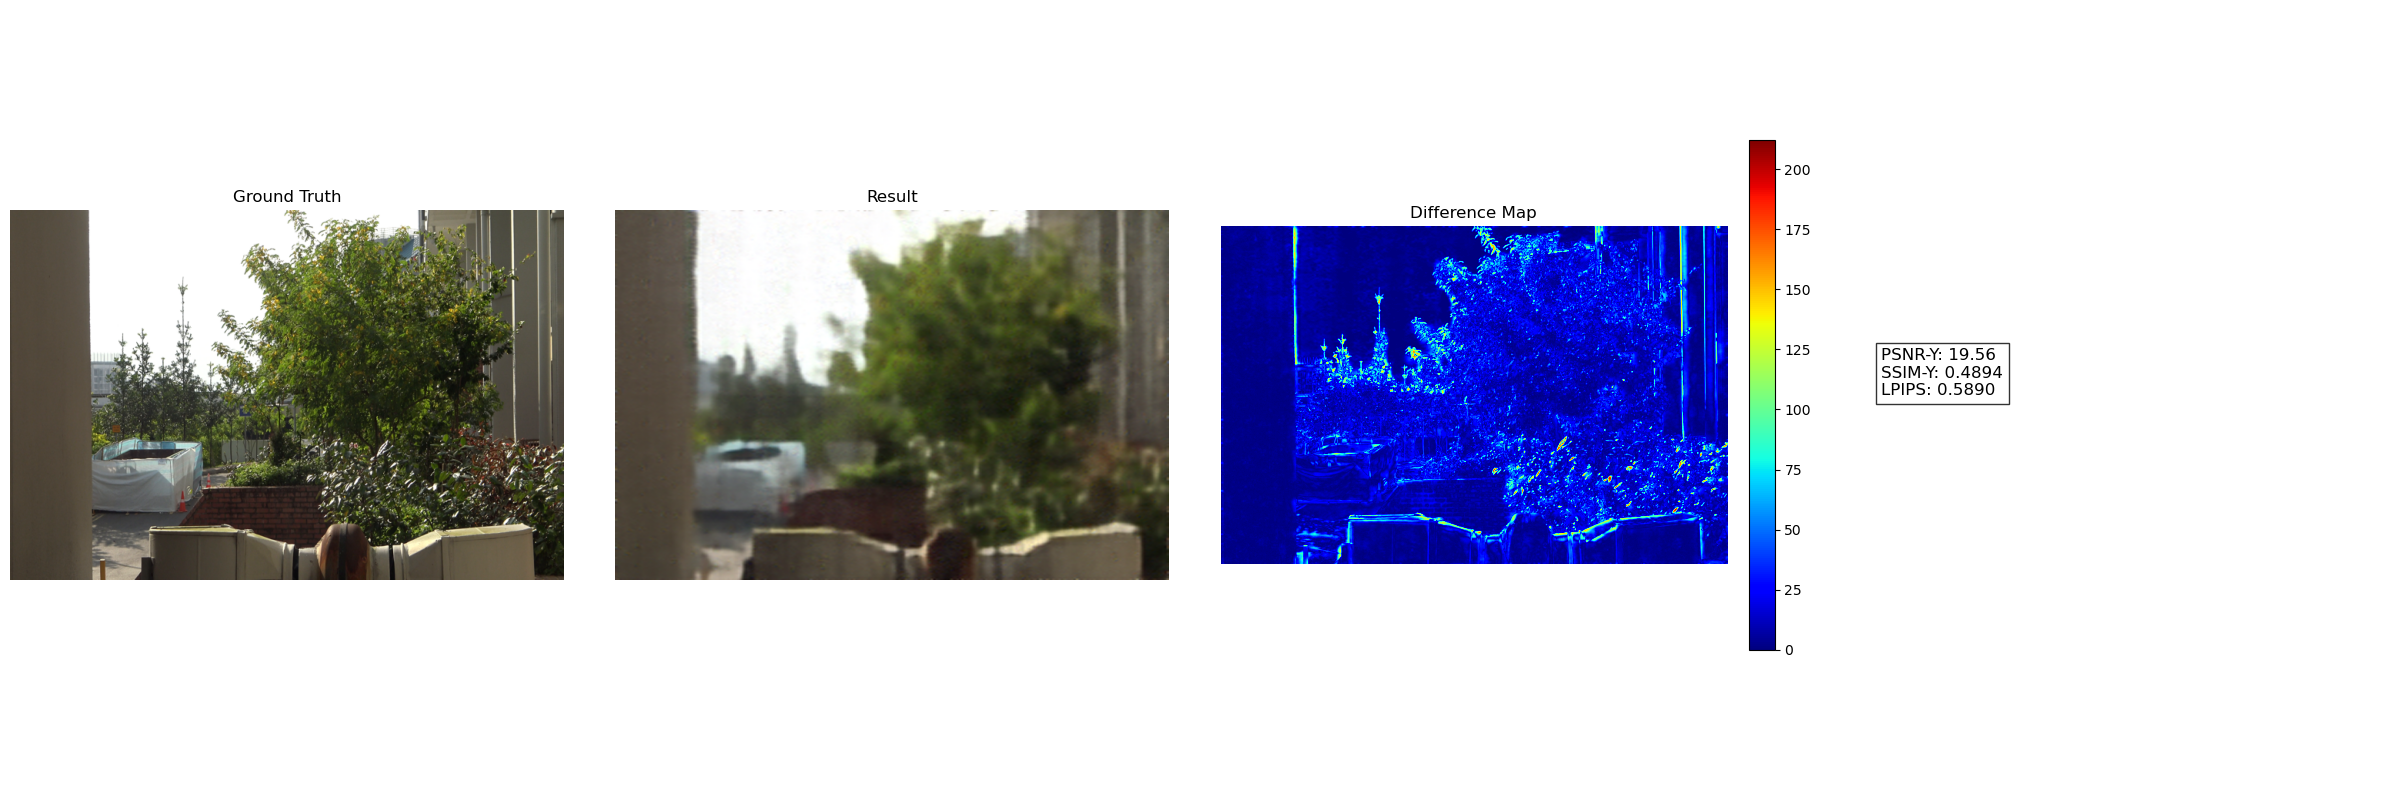

Resizing 00004.png from (256, 256) to (480, 720)
Resizing 00005.png from (256, 256) to (480, 720)
Resizing 00006.png from (256, 256) to (480, 720)
Resizing 00007.png from (256, 256) to (480, 720)
Resizing 00008.png from (256, 256) to (480, 720)
Resizing 00009.png from (256, 256) to (480, 720)
Resizing 00010.png from (256, 256) to (480, 720)
Resizing 00011.png from (256, 256) to (480, 720)
Resizing 00012.png from (256, 256) to (480, 720)
Resizing 00013.png from (256, 256) to (480, 720)
Resizing 00014.png from (256, 256) to (480, 720)
Resizing 00015.png from (256, 256) to (480, 720)
Resizing 00016.png from (256, 256) to (480, 720)
Resizing 00017.png from (256, 256) to (480, 720)
Resizing 00018.png from (256, 256) to (480, 720)
Resizing 00019.png from (256, 256) to (480, 720)
Resizing 00020.png from (256, 256) to (480, 720)

Summary Metrics:
Average PSNR-Y: 19.5224
Average SSIM-Y: 0.4836
Average LPIPS: 0.6048
Final Challenge Score: 21.3349


In [7]:
gt_dir = "E:/CV/RainDrop/clear"    # Ground Truth
result_dir = "E:/CV/RainDrop/Uformer/DayRainDrop_Train/output" # 结果
output_dir = "E:/CV/RainDrop/results"  # 保存

final_metrics, all_metrics = process_images(
    gt_dir=gt_dir,
    result_dir=result_dir,
    output_dir=output_dir,  # 设为None则不保存对比图
    show_samples=3          # 显示前3个样本的对比图
)